In [2]:
import os
import sys
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import pickle

In [3]:
%load_ext autoreload
%autoreload 2

In [435]:
# statmech library setup
sys.path.append('../../statmechlib')
from statmechlib.preprocessing import select_nodes, to_param_dict, to_param_list, insert_zero_params, rescale_manybody_params
from statmechlib.preprocessing import Trajectory, find_index, pair_dist_cutoff, universal_eos
from statmechlib.forcefields import utot_EAM_per_atom, utot_EAM_per_box, udif_print, u_core
from statmechlib.read_write import params_to_pickle

In [436]:
target_proc = '../data/target_processed'
working = '../data/working'
reports = '../reports'
pot_path = '../sim/potentials'

In [6]:
params_file = 'marinica_params'
stats_file = 'stats_marinica'
target_file = 'target_marinica'
stats_file = 'stats_manyknots' # 'stats_samples'
target_file = 'target_manyknots' # 'target_samples'
params_file = 'marinica_params'
stats_file = 'stats_manymd' # 'stats_samples'
target_file = 'target_manymd' # 'target_samples'
#stats_file = 'stats_manyvac' # 'stats_samples'
#target_file = 'target_manyvac' # 'target_samples'

stats_file = 'stats_test' # 'stats_samples'
target_file = 'target_test' # 'target_samples'
stats_file = 'stats_manyall' # 'stats_samples'
target_file = 'target_manyall' # 'target_samples'
# stats_file = 'stats_everyzero' # 'stats_samples'
# target_file = 'target_everyzero' # 'target_samples'
# stats_file = 'stats_manyknots' # 'stats_samples'
# target_file = 'target_manyknots' # 'target_samples'
stats_md_file = 'stats_onlymd' # 'stats_samples'
target_md_file = 'target_onlymd' # 'stats_samples'
#stats_file = 'stats_everything' # 'stats_samples'
#target_file = 'target_everything' # 'target_samples'

In [7]:
with open(os.path.join(working, stats_md_file+'.pickle'), 'rb') as fi:
    stats_md = pickle.load(fi)
    
with open(os.path.join(working, target_md_file+'.pickle'), 'rb') as fi:
    targets_md = pickle.load(fi)

with open(os.path.join(working, stats_file+'.pickle'), 'rb') as fi:
    stats_all = pickle.load(fi)

with open(os.path.join(working, target_file+'.pickle'), 'rb') as fi:
    targets = pickle.load(fi)

with open(os.path.join(working, params_file + '.pickle'), 'rb') as fi:
    param_list = pickle.load(fi)  

In [8]:
# # extended knots
# pair_knots = [ 2.45, 2.5648975,  2.629795 ,  2.6946925,  2.8663175,  2.973045 ,
#         3.0797725,  3.5164725,  3.846445 ,  4.1764175,  4.700845 ,
#         4.8953   ,  5.089755 ,  5.3429525,  5.401695 ,  5.4604375, 5.78]
# edens_knots = [ 2.5,  3.1,  3.5,  4.9, 5.5]

# pair_knots = [ 2.5648975,  2.629795 ,  2.6946925,  2.8663175,  2.973045 ,
#         3.0797725,  3.5164725,  3.846445 ,  4.1764175,  4.700845 ,
#         4.8953   ,  5.089755 ,  5.3429525,  5.401695 ,  5.4604375]
# edens_knots = [ 2.5,  3.1,  3.5,  4.9]

# pair_knots = [ 2.3, 2.5648975,  2.629795 ,  2.6946925,  2.8663175,  2.973045 ,
#         3.0797725,  3.5164725,  3.846445 ,  4.1764175,  4.700845 ,
#         4.8953   ,  5.089755 ,  5.3429525,  5.401695 ,  5.4604375]
# edens_knots = [ 2.5,  3.1,  3.5,  4.9]

# pair_knots = [2.26, 2.5648975,  2.629795 ,  2.6946925,  2.8663175,  2.973045 ,
#         3.0797725,  3.5164725,  3.846445 ,  4.1764175,  4.700845 ,
#         4.8953   ,  5.089755 ,  5.3429525,  5.401695 ,  5.4604375]
# edens_knots = [ 2.5,  3.1,  3.5,  4.9]

# pair_knots = [2.26, 2.5648975,  2.629795 ,  2.6946925,  2.8663175,  2.973045 ,
#         3.0797725,  3.5164725,  3.846445 ,  4.1764175,  4.700845 ,
#         4.8953   ,  5.089755 ,  5.3429525,  5.401695 ,  5.4604375]
# edens_knots = [ 2.5,  3.1,  3.5,  4.9]

In [167]:
stats_all['hyperparams']

{u'edens': [2.1800000000000002,
  2.2200000000000002,
  2.2599999999999998,
  2.2999999999999998,
  2.3399999999999999,
  2.3799999999999999,
  2.4199999999999999,
  2.45,
  2.46,
  2.5,
  2.54,
  2.5648975,
  2.5800000000000001,
  2.6200000000000001,
  2.629795,
  2.6600000000000001,
  2.6946925,
  2.7000000000000002,
  2.7400000000000002,
  2.7799999999999998,
  2.8199999999999998,
  2.8599999999999999,
  2.8663175,
  2.8999999999999999,
  2.9399999999999999,
  2.973045,
  2.98,
  3.02,
  3.0600000000000001,
  3.0797725,
  3.1000000000000001,
  3.1400000000000001,
  3.1800000000000002,
  3.2200000000000002,
  3.2599999999999998,
  3.2999999999999998,
  3.3399999999999999,
  3.3799999999999999,
  3.4199999999999999,
  3.46,
  3.5,
  3.5164725,
  3.54,
  3.5800000000000001,
  3.6200000000000001,
  3.6600000000000001,
  3.7000000000000002,
  3.7400000000000002,
  3.7799999999999998,
  3.8199999999999998,
  3.846445,
  3.8599999999999999,
  3.8999999999999999,
  3.9399999999999999,
  3.9

In [9]:
def downselect(stats_inp, pair_knots, edens_knots):
    
    # find idices of knots
    pair_index = find_index(pair_knots, stats_inp['hyperparams']['pair'])
    edens_index = find_index(edens_knots, stats_inp['hyperparams']['edens'])
    
    # create boolean arrays with select indices set to True
    p_ix = np.array([True if i in pair_index else False for i in range(len(stats_inp['hyperparams']['pair']))])
    m_ix = np.array([True if i in edens_index else False for i in range(len(stats_inp['hyperparams']['edens']))])

    stats_out = select_nodes(stats_inp, p_ix, m_ix)
    
    return stats_out

In [481]:
# pair_knots = [2.22, 2.46, 2.5648975,  2.629795 ,  2.6946925,  2.8663175,  2.973045 ,
#         3.0797725,  3.5164725,  3.846445 ,  4.1764175,  4.700845 ,
#         4.8953   ,  5.089755 ,  5.3429525,  5.401695 ,  5.4604375]
# edens_knots = [ 2.5, 2.8663175, 3.1,  3.5,  4.5, 4.9, 5.4604375]

# pair_knots = [2.22, 2.46, 2.5648975,  2.629795 ,  2.6946925,  2.8663175,  2.973045 ,
#         3.0797725,  3.5164725,  3.846445 ,  4.1764175,  4.700845 ,
#         4.8953   ,  5.089755 ,  5.3429525,  5.401695 ,  5.4604375]
# edens_knots = [ 2.5, 2.8663175, 3.1,  3.5,  4.5, 4.9]

# pair_knots = [2.22, 2.46, 2.5648975,  2.629795 ,  2.6946925,  2.8663175,  2.973045 ,
#         3.0797725,  3.5164725,  3.846445 ,  4.1764175,  4.700845 ,
#         4.8953   ,  5.089755 ,  5.3429525,  5.401695 ,  5.4604375]
# edens_knots = [ 2.22, 2.5,  2.6946925, 2.8663175, 3.1,  3.5,  4.5, 4.9]

pair_knots = [2.22, 2.46, 2.5648975,  2.629795 ,  2.6946925,  2.74, 2.8663175,  2.973045 ,
        3.0797725,  3.5164725,  3.846445 ,  4.1764175,  4.700845 ,
        4.8953   ,  5.089755 ,  5.3429525,  5.401695 ,  5.4604375]
edens_knots = [ 2.22, 2.5,  2.6946925, 2.8663175, 3.1,  3.5,  4.62, 4.9]

In [482]:
stats = downselect(stats_all, pair_knots, edens_knots)
print(stats['hyperparams'])
# stats_select_md = downselect(stats_md, pair_knots, edens_knots)
# print(stats_select_md['hyperparams'])

{u'pair': [2.2200000000000002, 2.46, 2.5648974999999998, 2.6297950000000001, 2.6946924999999999, 2.7400000000000002, 2.8663175000000001, 2.9730449999999999, 3.0797724999999998, 3.5164724999999999, 3.8464450000000001, 4.1764175000000003, 4.7008450000000002, 4.8952999999999998, 5.0897550000000003, 5.3429525, 5.4016950000000001, 5.4604375000000003], u'edens': [2.2200000000000002, 2.5, 2.6946924999999999, 2.8663175000000001, 3.1000000000000001, 3.5, 4.6200000000000001, 4.9000000000000004]}


In [483]:
# targets['md'] = targets_md['md']
# stats['md'] = stats_select_md['md']

In [484]:
# for key in sorted(targets.keys()):
#     #if 'bcc_npt' not in key:
#     #    continue
#     for box, xyz, ene in zip(targets[key]['box'], targets[key]['xyz'], stats[key]['energy']):
#         #print(np.linalg.det(box), len(xyz), len(ene), type(ene))
#         n = len(xyz)
#         vol = np.linalg.det(box)
#         corr = float(n*n)/vol
#         #print(n, corr)
#         ene.append([corr])

In [485]:
# optimal_params = []
# for params in param_list:
#     eam_params = list(params['params']['embed']) + list(params['params']['pair']) + list(params['params']['edens'])
#     #eam_params = list(params['params']['embed']) + [0.0] + list(params['params']['pair']) + [0.0] + list(params['params']['edens']) + [0.0]
#     optimal_params.append((0.0, np.array(eam_params)))

In [494]:
# # The three potentials below were produced with these knots
# # pair_knots = [2.22, 2.46, 2.5648975,  2.629795 ,  2.6946925,  2.8663175,  2.973045 ,
# #         3.0797725,  3.5164725,  3.846445 ,  4.1764175,  4.700845 ,
# #         4.8953   ,  5.089755 ,  5.3429525,  5.401695 ,  5.4604375]
# # edens_knots = [ 2.5, 2.8663175, 3.1,  3.5,  4.9, 5.4604375]

# # Marinica
# optimal_params = [(0.0, np.array([ -5.94645400e+00,  -4.94770000e-02,  0.0, 0.0, 9.60851701e+01,
#           -1.84410924e+02,   9.35784080e+01,  -7.98358265e+00,
#            7.47034093e+00,  -1.52756044e+00,   1.25205933e+00,
#            1.63082162e+00,  -1.41854775e+00,  -8.19936046e-01,
#            1.98013514e+00,  -6.96430180e-01,   3.04546910e-02,
#           -1.63131143e+00,   1.38409896e+00,  -4.20429108e+00, 0.0,
#            5.18217702e-01,   5.62720800e-02,   0.0, 3.44164179e-02, 0.0]))]

# # no zero of energy
# optimal_params.append((7.5819554904579912e-07, np.array([ -3.89737656e+00,  -2.57834426e-03,  -8.23938847e+02,
#          2.16658249e+02,   5.01505312e+01,  -1.77871167e+01,
#          2.71971841e+01,  -1.20150521e+01,   1.85112916e+01,
#         -4.95159705e+00,   1.04854525e+00,   1.29923012e+00,
#         -1.01714733e+00,  -6.91733901e-01,   1.99779222e+00,
#         -9.31282783e-01,  -8.08328181e-02,  -1.56599210e+00,
#          1.47225354e+00,   1.99295950e+02,   2.64875790e-01,
#          3.54922815e+00,  -1.37958117e-01,   0.0, 6.91962731e-02,
#          6.21913798e-06])))

# zero of energy
# optimal_params.append((2.8099138621896525e-06, np.array([ -3.27882058e+00,  -9.77681860e-04,  -5.95486537e+02,
#          3.42401535e+02,  -4.15497479e+02,   3.71316746e+02,
#         -1.07274610e+02,  -2.93282898e+00,   1.51298572e+01,
#         -1.37454674e+01,   8.16724633e+00,  -3.16850352e+00,
#          8.74607042e-01,  -1.07878768e+00,   1.97939820e+00,
#         -8.26149646e-01,  -1.62437297e-01,  -1.45694910e+00,
#          1.42153527e+00,   1.29203135e+02,  -9.25284676e+00,
#          2.63967417e+00,   2.06410900e+00,   0.0, 6.03258240e-02,
#          5.85208452e-13])))

# #***********************************

# # The three potentials below were produced with these knots
# # pair_knots = [2.22, 2.46, 2.5648975,  2.629795 ,  2.6946925,  2.8663175,  2.973045 ,
# #         3.0797725,  3.5164725,  3.846445 ,  4.1764175,  4.700845 ,
# #         4.8953   ,  5.089755 ,  5.3429525,  5.401695 ,  5.4604375]
# # edens_knots = [ 2.5, 2.8663175, 3.1,  3.5,  4.5]

# optimal_params = [(0.0, np.array([ -5.94645400e+00,  -4.94770000e-02,  0.0, 0.0, 9.60851701e+01,
#           -1.84410924e+02,   9.35784080e+01,  -7.98358265e+00,
#            7.47034093e+00,  -1.52756044e+00,   1.25205933e+00,
#            1.63082162e+00,  -1.41854775e+00,  -8.19936046e-01,
#            1.98013514e+00,  -6.96430180e-01,   3.04546910e-02,
#           -1.63131143e+00,   1.38409896e+00,  -4.20429108e+00, 0.0,
#            5.18217702e-01,   5.62720800e-02,   0.0, 3.44164179e-02]))]

# # no zero of energy
# optimal_params.append((7.2120521404658548e-07, np.array([ -3.82648588e+00,  -3.15395324e-03,  -7.04235860e+02,
#          2.24162391e+02,   6.00323185e+01,  -2.50405997e+01,
#          3.08538238e+01,  -1.21719898e+01,   1.66904242e+01,
#         -3.84273118e+00,   8.34954792e-01,   1.12083715e+00,
#         -7.94620177e-01,  -6.05852952e-01,   2.03652986e+00,
#         -1.03495446e+00,  -1.20820798e-01,  -1.55518420e+00,
#          1.50033948e+00,   2.09695356e+02,   1.05734976e-02,
#          3.52470642e+00,  -2.47034958e-01,   1.52735787e-01, 0.0])))

# # zero of energy
# optimal_params.append((2.655472284832525e-06, np.array([ -3.56709315e+00,  -2.97358686e-03,  -4.37632666e+02,
#          3.35095381e+02,  -2.95083648e+02,   2.94263473e+02,
#         -8.57731610e+01,  -1.62036228e+01,   1.30838141e+01,
#         -6.46551376e+00,   8.01826587e+00,  -3.58786095e+00,
#          1.25735987e+00,  -1.21627097e+00,   2.04033545e+00,
#         -8.04702913e-01,  -1.92666480e-01,  -1.44083371e+00,
#          1.41816098e+00,   1.70360405e+02,  -1.89070431e+01,
#          7.47139804e+00,   1.20540194e+00,   1.34588181e-01, 0.0])))



optimal_params = [(0.0, np.array([ -5.94645400e+00,  -4.94770000e-02,  0.0, 0.0, 9.60851701e+01,
          -1.84410924e+02,   9.35784080e+01,  0.0, -7.98358265e+00,
           7.47034093e+00,  -1.52756044e+00,   1.25205933e+00,
           1.63082162e+00,  -1.41854775e+00,  -8.19936046e-01,
           1.98013514e+00,  -6.96430180e-01,   3.04546910e-02,
          -1.63131143e+00,   1.38409896e+00,  0.0, -4.20429108e+00, 0.0,0.0,
           5.18217702e-01,   5.62720800e-02,   0.0, 3.44164179e-02]))]

#[ 2.22, 2.5,  2.6946925, 2.8663175, 3.1,  3.5,  4.5, 4.9]

# optimal_params.append((2.4463767622330787e-06, np.array([ -3.94215706e+00,  -5.55514945e-03,  -3.46604268e+02,
#          3.11141077e+02,  -2.27631469e+02,   2.46083420e+02,
#         -7.20824733e+01,  -3.45508767e+01,   1.24728443e+01,
#         -2.42416608e+00,   8.01297720e+00,  -3.46654527e+00,
#          1.29818620e+00,  -1.32482089e+00,   2.05474779e+00,
#         -8.38519277e-01,  -1.79115529e-01,  -1.42663497e+00,
#          1.45553080e+00,   1.51540935e+02,  -2.78003351e+01,
#          8.29742334e+00,   1.10996625e+00,   9.94816279e-02, 0.0,
#         -4.42869043e+01])))

# optimal_params.append((2.9764772659242589e-06, np.array([ -5.90666878e+00,   1.55202206e-02,  -6.26812375e+02,
#          3.31291324e+02,  -5.10046060e+02,   4.33069278e+02,
#         -1.23148759e+02,  -6.77116884e-01,   4.48820066e+00,
#          6.17386076e-01,   3.80779462e+00,  -1.97729325e+00,
#          3.81483535e-01,  -5.77577277e-01,   1.91131244e+00,
#         -1.16378695e+00,  -1.15291195e-01,  -1.52667935e+00,
#          1.57872639e+00,   2.25035205e+01,  -3.58905561e+00,
#          3.02775051e+00,  -2.46493000e-01,   6.44009993e-02, 0.0,
#         -4.40979057e+01])))

# optimal_params.append((7.1701510475475117e-07, np.array([ -3.95161359e+00,  -3.44448407e-03,  -7.14607618e+02,
#          2.24304627e+02,   5.58772552e+01,  -2.41280180e+01,
#          3.08660997e+01,  -1.06362770e+01,   1.60112855e+01,
#         -3.43963957e+00,   8.16007015e-01,   1.05972458e+00,
#         -7.79283256e-01,  -5.99024624e-01,   2.04588701e+00,
#         -1.03749080e+00,  -1.32949131e-01,  -1.55197130e+00,
#          1.50188689e+00,   1.95329316e+02,   7.96203281e-01,
#          3.40689082e+00,  -2.97810062e-01,   1.46943185e-01, 0.0,
#          0.0]))) #4.19657735e+00

# optimal_params.append((7.0866557249164835e-07, np.array([ -3.78191508e+00,  -2.29559629e-03,  -7.00381659e+02,
#          1.93325097e+02,   3.37902757e+01,  -1.83210883e+01,
#          3.04151009e+01,  -9.99342165e+00,   1.54259392e+01,
#         -2.71373977e+00,   6.44180792e-01,   1.02897552e+00,
#         -7.50244822e-01,  -6.02888191e-01,   2.05123916e+00,
#         -1.04354339e+00,  -1.64386918e-01,  -1.54387765e+00,
#          1.52431780e+00,   1.79667873e+02,   1.22279986e+00,
#          3.99611914e+00,  -4.41834931e-01,   1.62121921e-01, 0.0,
#          4.06295846e-01]))) #

# optimal_params.append((7.0203106955348125e-07, np.array([ -3.91050922e+00,  -3.58200201e-03,  -6.99584889e+02,
#          2.33989111e+02,   1.04132222e+02,  -5.69974715e+01,
#          4.22990605e+01,  -1.67015822e+01,   1.54096896e+01,
#         -7.00711322e-01,   4.94371835e-01,   1.05428858e+00,
#         -7.24094984e-01,  -6.38208084e-01,   2.09639444e+00,
#         -1.06529597e+00,  -1.90927102e-01,  -1.53841395e+00,
#          1.54612418e+00,   2.28170241e+02,  -2.63164086e+00,
#          4.77073224e+00,  -4.55727595e-01,   1.53656127e-01,
#         -2.46946053e+00])))

# optimal_params.append((6.9595317711028418e-07, np.array([ -3.89054208e+00,  -2.99469508e-03,  -7.60325091e+02,
#          2.25922421e+02,   4.31682139e+01,  -2.00879587e+01,
#          3.15977299e+01,  -1.41216383e+01,   1.40729549e+01,
#         -2.29741069e-01,   5.66020784e-01,   9.50813370e-01,
#         -7.07877506e-01,  -6.33885976e-01,   2.11514130e+00,
#         -1.07084535e+00,  -1.99471358e-01,  -1.53976066e+00,
#          1.54749579e+00,   1.94668273e+02,  -1.93218649e+00,
#          4.87330211e+00,  -4.95019886e-01,   1.54561460e-01, 0.0,
#          2.56347500e-01])))

# optimal_params.append((7.7089827957963725e-07, np.array([ -3.80093177e+00,  -6.54314240e-03,  -1.92772247e+02,
#          2.38233233e+02,   6.15973897e+01,  -8.93221408e+00,
#          1.39838077e+01,  -5.32923282e+01,   1.49334013e+01,
#          1.50226447e+00,   5.83476471e+00,  -9.58233306e-01,
#          3.02147651e-01,  -1.21905200e+00,   2.15324504e+00,
#         -9.19832968e-01,  -1.82213654e-01,  -1.44709115e+00,
#          1.46070434e+00,   1.94585129e+02,  -3.39717278e+01,
#          8.74276750e+00,   1.72989722e+00,   7.78276260e-02, 0.0,
#          -1.91289845e+01])))

# optimal_params.append((1.1589816706119542e-06, np.array([ -2.76762846e+00,   1.89330096e-03,  -3.78969507e+02,
#          4.97375946e+01,   5.61080362e+01,  -8.13991417e+01,
#          6.18213043e+01,  -3.36881958e+01,   9.64679581e+00,
#          6.37021438e+00,   2.56205745e+00,  -6.89271288e-02,
#         -8.28256696e-01,  -5.90663693e-01,   2.19738636e+00,
#         -9.78519868e-01,  -2.34054246e-01,  -1.56404102e+00,
#          1.50934562e+00,   1.25199350e+02,  -2.58933860e+01,
#          1.60206690e+01,  -2.46344691e-01,   1.98323959e-01, 0.0,
#         0.0])))

# optimal_params.append((1.1473187764901127e-06, np.array([ -2.75229934e+00,   1.47535377e-03,  -3.69002933e+02,
#          6.44372722e+01,   3.04821653e+01,  -6.09129442e+01,
#          5.36281092e+01,  -3.06081878e+01,   7.50580436e+00,
#          7.14437316e+00,   2.56143771e+00,   8.17139676e-03,
#         -8.39767092e-01,  -6.13655140e-01,   2.20014058e+00,
#         -9.65398383e-01,  -2.37743863e-01,  -1.56236311e+00,
#          1.50832311e+00,   1.17014449e+02,  -2.48764493e+01,
#          1.58598600e+01,  -4.72056862e-02,   1.96659110e-01, 0.0,
#         -7.77462173e+06])))

# optimal_params.append((1.0210275855014546e-06, np.array([ -2.83157185e+00,   8.39115358e-04,  -4.21330968e+02,
#          5.62354559e+01,   6.55868693e+01,  -7.39097694e+01,
#          5.32753168e+01,  -2.90768080e+01,   9.73480693e+00,
#          5.86938247e+00,   2.40344261e+00,   1.33807130e-01,
#         -7.34188649e-01,  -8.53691403e-01,   2.20105517e+00,
#         -7.61586871e-01,  -2.42532670e-01,  -1.58457873e+00,
#          1.47655687e+00,   1.48755630e+02,  -1.98109911e+01,
#          1.44803287e+01,  -1.17489342e-01,   2.06651900e-01, 0.0])))

# optimal_params.append((1.004651314998124e-06, np.array([ -2.84299893e+00,   7.74316066e-04,  -2.60185762e+02,
#          2.12100147e+01,   3.52845699e+01,  -6.93103301e+01,
#          7.95717459e+01,  -3.39400457e+01,   9.42654140e+00,
#          5.61056055e+00,   2.45706583e+00,   2.28984411e-01,
#         -7.34032706e-01,  -8.98635826e-01,   2.20701099e+00,
#         -7.55061461e-01,  -2.30027272e-01,  -1.58424621e+00,
#          1.47015547e+00,   5.39975665e+01,   5.25810283e+01,
#          4.00257405e+01,  -2.81864073e+01,   1.39508804e+01,
#          1.74493416e-01,   1.98910760e-01, 0.0])))

# optimal_params.append((9.8870206248073463e-07, np.array([ -3.36853915e+00,   8.06754487e-04,  -2.63564571e+02,
#          1.50313698e+01,   4.21907571e+01,  -5.73531064e+01,
#          8.35165366e+01,  -3.69788026e+01,   9.58749779e+00,
#          6.16845079e+00,   2.49238513e+00,   2.39879577e-01,
#         -7.08240245e-01,  -1.04050858e+00,   2.29383862e+00,
#         -7.07114275e-01,  -2.72304655e-01,  -1.55975977e+00,
#          1.45892855e+00,   4.33363673e+01,   6.04909283e+01,
#          4.04214288e+01,  -2.34985547e+01,   1.03464548e+01,
#          2.09123995e-01,   1.10440817e-01, 0.0])))

optimal_params.append((9.8235985922867908e-07, np.array([ -3.34519702e+00,   7.66822271e-04,  -4.03553412e+02,
         1.55282185e+01,   2.90516401e+01,  -6.23087513e+01,
         8.48184009e+01,  0.0, -3.48806112e+01,   9.13550274e+00,
         5.96096071e+00,   2.54062374e+00,   2.39873080e-01,
        -7.19239652e-01,  -1.04267291e+00,   2.29366373e+00,
        -7.05206149e-01,  -2.72279799e-01,  -1.55954882e+00,
         1.45964251e+00,  -2.01431222e+02,   3.24297105e+01,
         3.81664135e+01,  -2.18948938e+01,   1.02484895e+01,
         2.20300623e-01,   1.13874983e-01, 0.0])))

optimal_params.append((9.5627220241236022e-07, np.array([ -3.28713435e+00,   5.59666662e-04,  -3.34726292e+02,
        -2.27574754e+00,   9.18504307e+01,  -1.33800184e+02,
         1.41621793e+02,  -3.53595078e+01,  -1.93229183e+01,
         2.80476272e+00,   5.01534480e+00,   2.92092859e+00,
         4.14229221e-01,  -8.17215257e-01,  -1.06954550e+00,
         2.30100580e+00,  -6.78418479e-01,  -2.59082983e-01,
        -1.56674300e+00,   1.44449711e+00,  -8.59623724e+01,
         4.85827497e+01,   3.41381628e+01,  -1.77461766e+01,
         7.88769975e+00,   8.35711599e-01,   1.01302596e-01, 0.0])))

In [495]:
def plot_udif(targets, stats, traj_name, selected_params, select=slice(None, None, None), x_lim=None, y_lim=None, x_ticks=None, shift=0.0, verbose=0):

    plt.figure(figsize=(20,10))

    plt.title(traj_name, fontsize=30)
    
    # get target energies
    opti_out, targ_out = udif_print(selected_params[0][1], targets, stats, utot_EAM_per_atom)

    #number of atoms in each configuration of this trajectory
    nat = np.array([len(x) for x in targets[traj_name]['xyz']])[select]
    #print(list(nat))
    
    # plot target energies
    #plt.plot(np.array(targ_out[traj_name])[select]/nat, 'o', label='target', markersize=5)
    plt.plot(np.array(targ_out[traj_name])[select], 'o', label='target', markersize=8)
    if verbose:
        print('u_target:',np.array(targ_out[traj_name])[select] )

    # get and plot optimized model energies
    for i, params in enumerate(selected_params):
        opti_out, targ_out = udif_print(params[1], targets, stats, utot_EAM_per_atom)
        #plt.plot(np.array([o for o in np.array(opti_out[traj_name])[select]])/nat, 'x--', label='optimized '+str(i))
        plt.plot(np.array([o for o in np.array(opti_out[traj_name])[select]])+shift, '.--', lw=2, label='optimized '+str(i))
        if verbose:
            print('u_model', i,':', [o for o in np.array(opti_out[traj_name])[select]])
    plt.legend(loc='best')#fontsize=30)
    
    # special requirements on axes
    if x_lim:
        plt.xlim(*x_lim)
    if y_lim:
        plt.ylim(*y_lim)
    if x_ticks:
        plt.xticks(*x_ticks)
    
    plt.xlabel('configuration #', fontsize=30)
    plt.ylabel('Energy [eV]', fontsize=30)
    
    plt.grid(True)
    
    plt.savefig(os.path.join(reports, traj_name+'.png'))

('u_target:', array([-1139.2       ,  -907.01548795, -1136.40101438, -1136.75081873,
       -1190.26117728, -1127.17469716]))
('u_model', 0, ':', [-1135.521815750772, -910.420440229723, -1136.0040042294886, -1136.1465574140611, -1188.680517051502, -1123.2983174217331])
('u_model', 1, ':', [-1137.7978088108525, -914.48708747398109, -1133.5402159053153, -1133.2489679711111, -1192.1448900663595, -1125.3706694155144])
('u_model', 2, ':', [-1138.3967187364578, -912.25698220617392, -1133.7346489924219, -1133.3317977208574, -1192.436994592116, -1125.9234934240344])


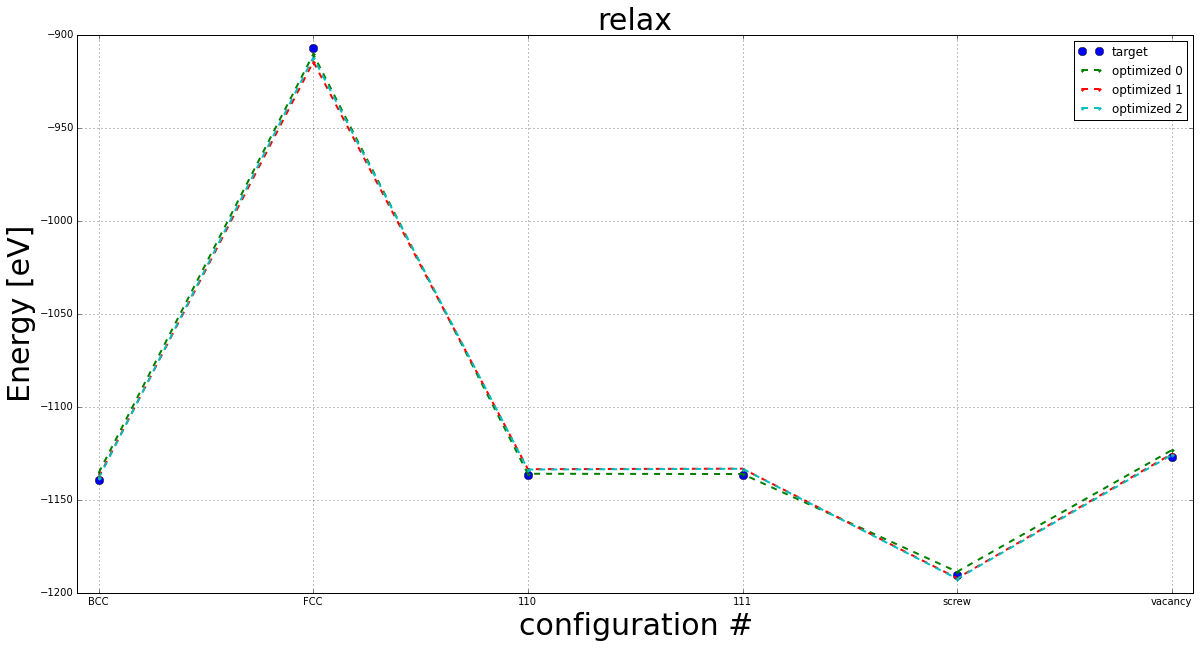

In [496]:
# plot relax
x_ticks = ([0, 1, 2, 3, 4, 5], ['BCC', 'FCC','110','111', 'screw', 'vacancy'])
x_lim=(-0.1, 5.1)
slice_end = len(x_ticks[0])
select = slice(0, slice_end, None)
plot_udif(targets, stats, 'relax', optimal_params, select=select, x_ticks=x_ticks, x_lim=x_lim, shift=0, verbose=1)#-37)#-36)

In [497]:
stat = {'relax':stats['relax'], 'hyperparams':stats['hyperparams'], 'function':stats['function']}
tar = {'relax':targets['relax']}
opt, ref = udif_print(optimal_params[1][1], tar, stat, utot_EAM_per_atom)
opt, ref

({'relax': [-1137.7978088108525,
   -914.48708747398109,
   -1133.5402159053153,
   -1133.2489679711111,
   -1192.1448900663595,
   -1125.3706694155144]},
 {'relax': [-1139.2,
   -907.0154879478124,
   -1136.4010143821092,
   -1136.7508187321096,
   -1190.2611772847656,
   -1127.1746971578905]})

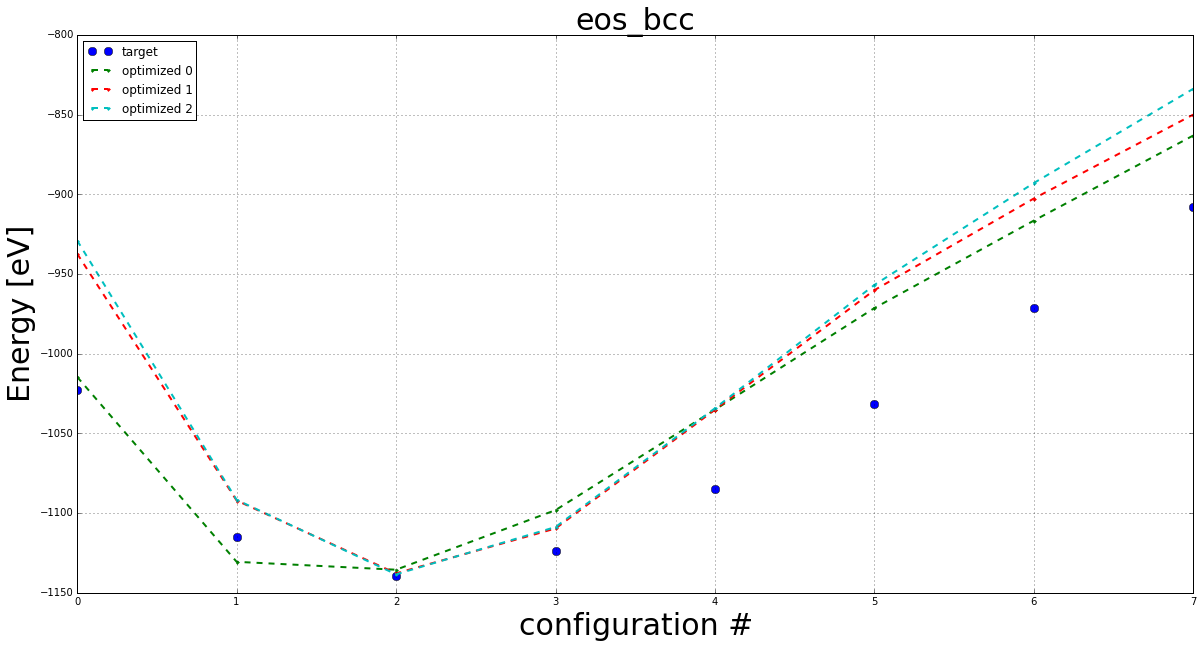

In [498]:
# plot bcc EOS
select = [10, 11, 6, 3, 4, 5, 7, 2, 1, 12, 13, 14, 15, 16, 17, 18]
select = [1, 2, 0, 3, 4, 5, 6, 7]
x_lim = (2, 8)
y_lim = (-9.0, -7.0)
plot_udif(targets, stats, 'eos_bcc', optimal_params, shift=0, select=select)#, x_lim=x_lim, y_lim=y_lim)

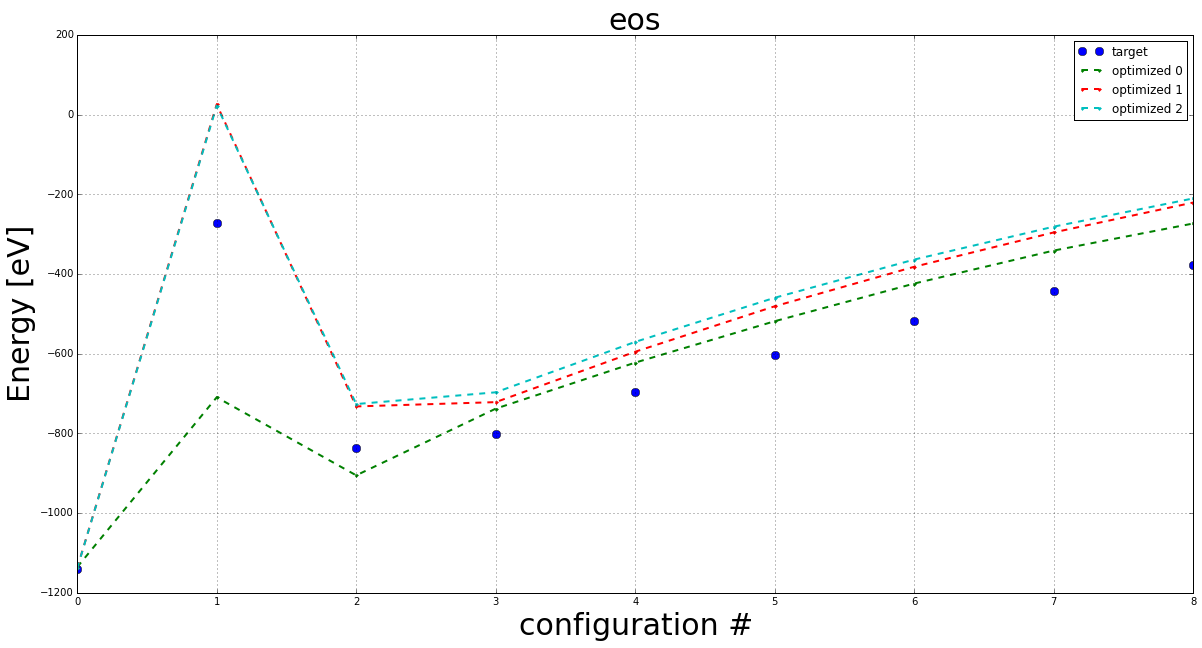

In [499]:
#select = [10, 11, 6, 3, 4, 5, 7, 2, 1, 12, 13, 14, 15, 16, 17, 18]
#x_lim = (2, 8)
#y_lim = (-9.0, -7.0)
plot_udif(targets, stats, 'eos', optimal_params, shift=0)#, select=select)#, x_lim=x_lim, y_lim=y_lim)

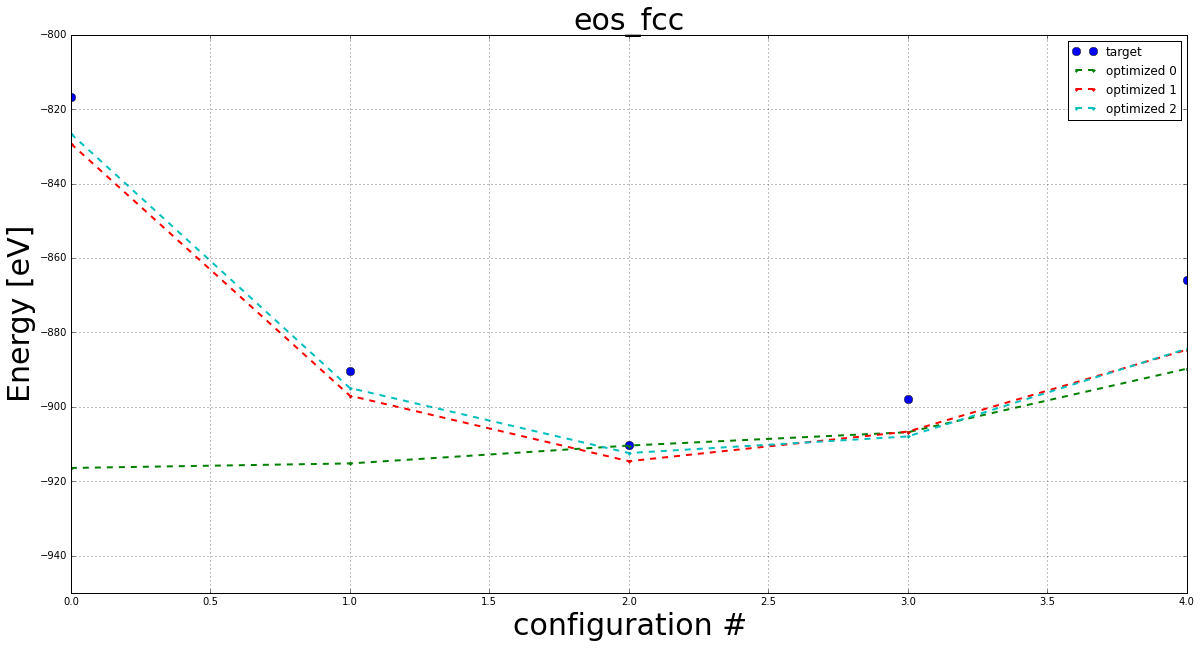

In [500]:
# plot fcc EOS
#select = [1, 2, 3, 0, 5, 6, 7, 4]
select = [1, 2, 0, 3, 4]
x_lim = (0, 4)
y_lim = (-950, -800)
plot_udif(targets, stats, 'eos_fcc', optimal_params, x_lim=x_lim, y_lim=y_lim, select=select, shift=0)#-36)#, select=select)


In [501]:
# # plot MD trajectories
# x_lim = (2.8,8.2)
# y_lim = (-2250,-2100)
# #x_lim = (-0.2,2.2)
# #y_lim = (-3880,-3780)

# plot_udif(targets, stats, 'vacint', optimal_params, x_lim=x_lim, y_lim=y_lim)#, shift=-80)
# plot_udif(targets, stats, 'vacint', optimal_params, shift=-78, x_lim=x_lim, y_lim=y_lim)#, shift=-24.2)
#108/128.*37

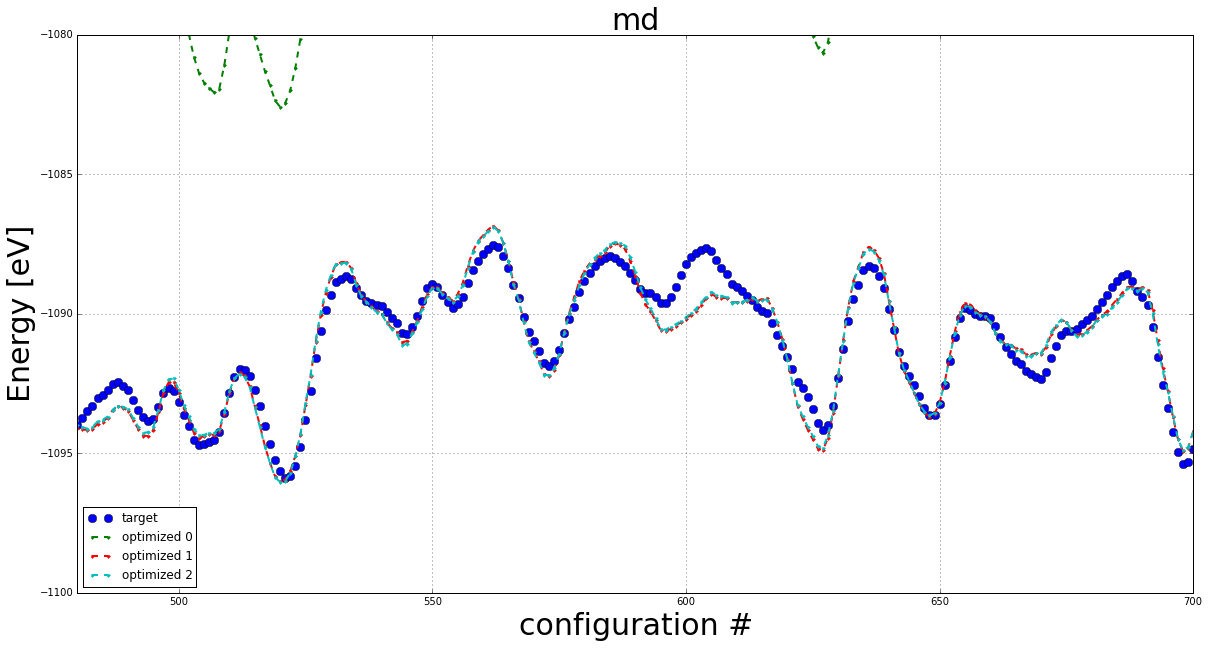

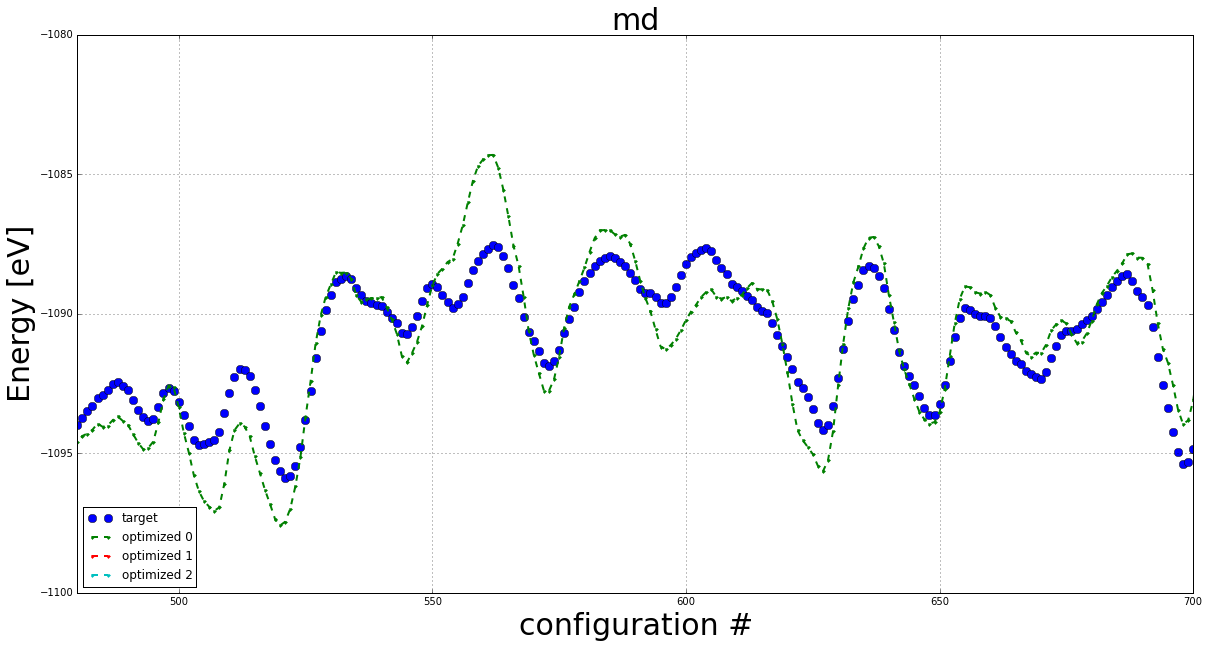

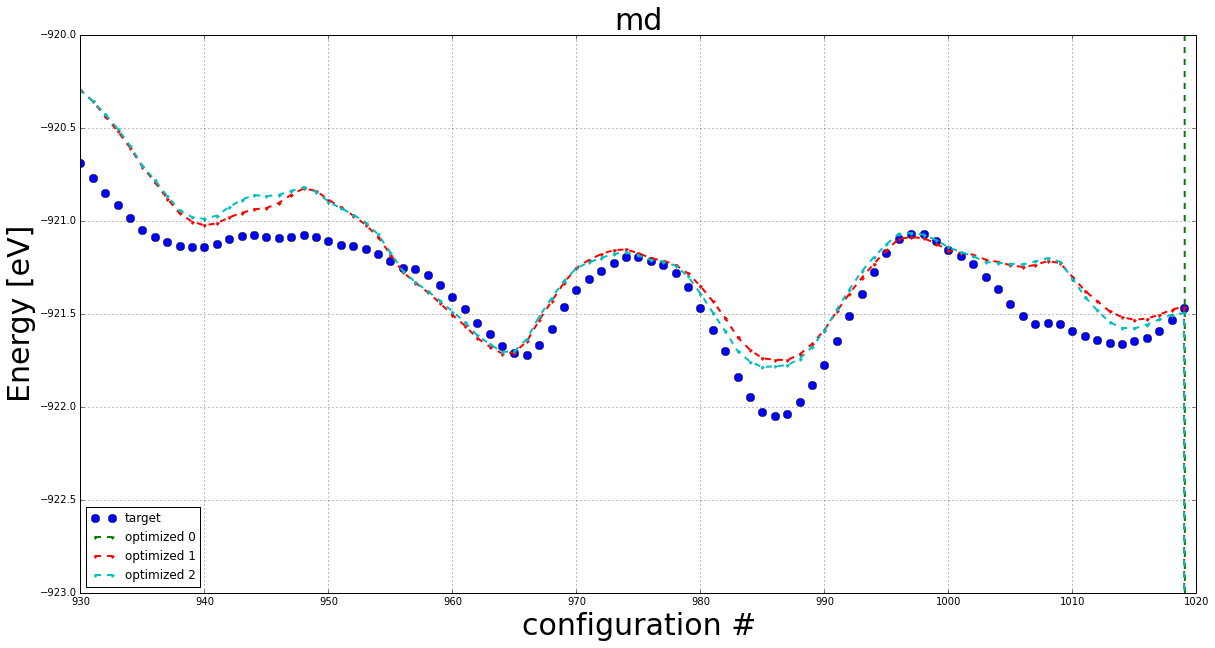

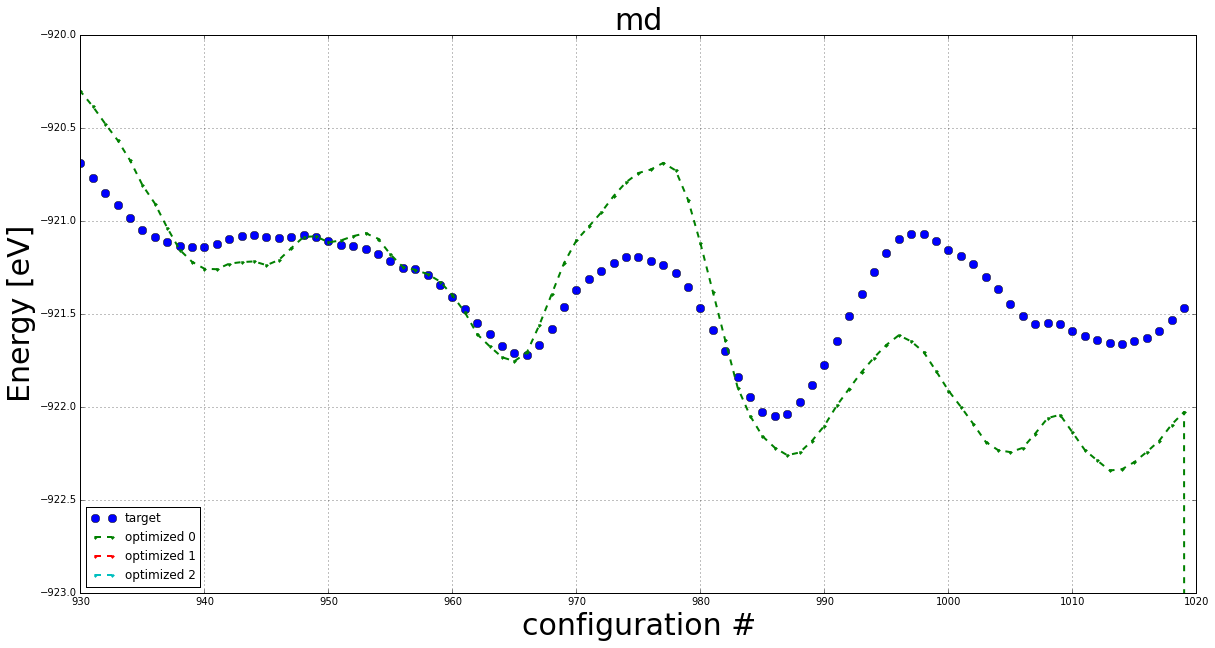

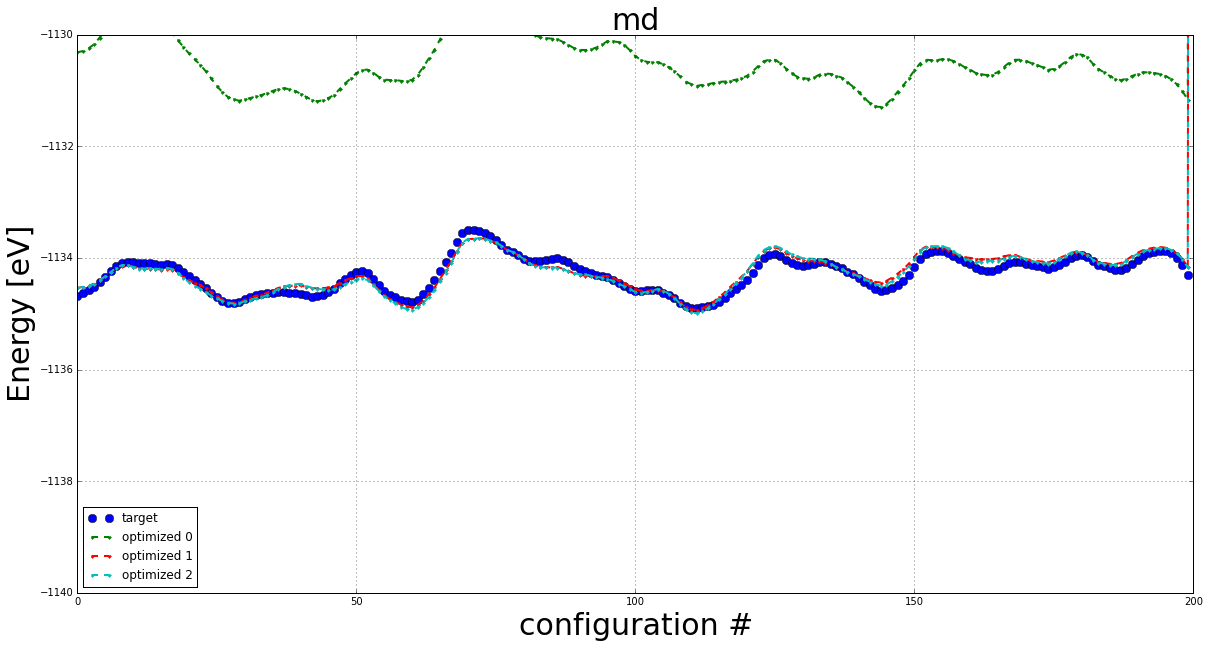

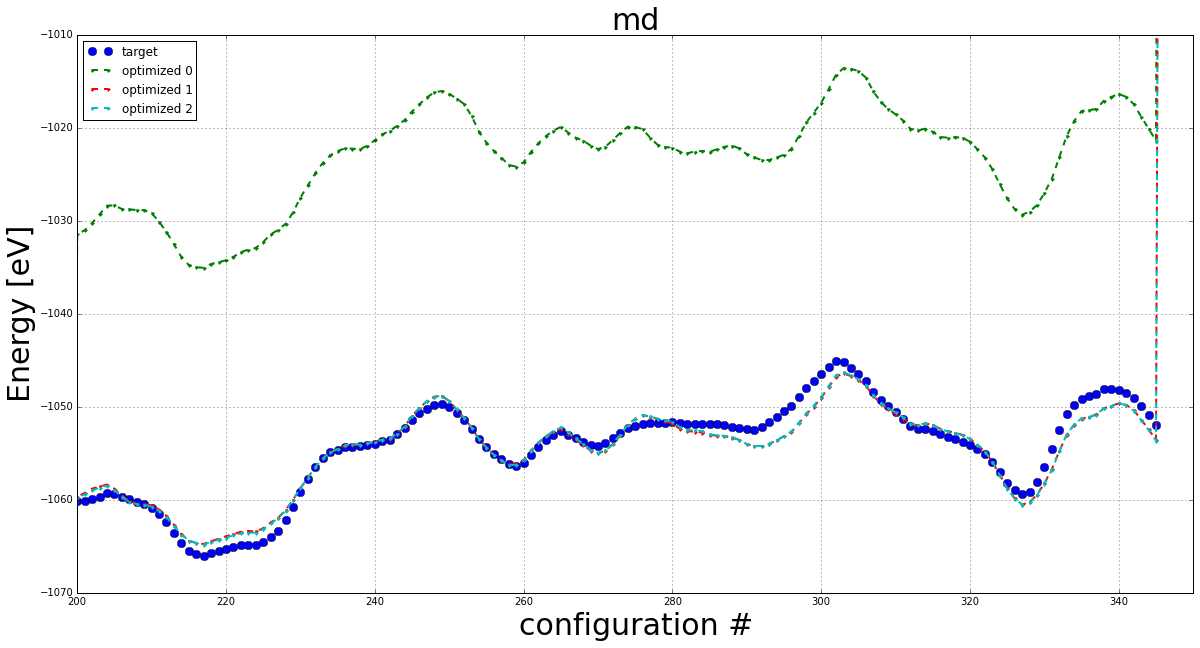

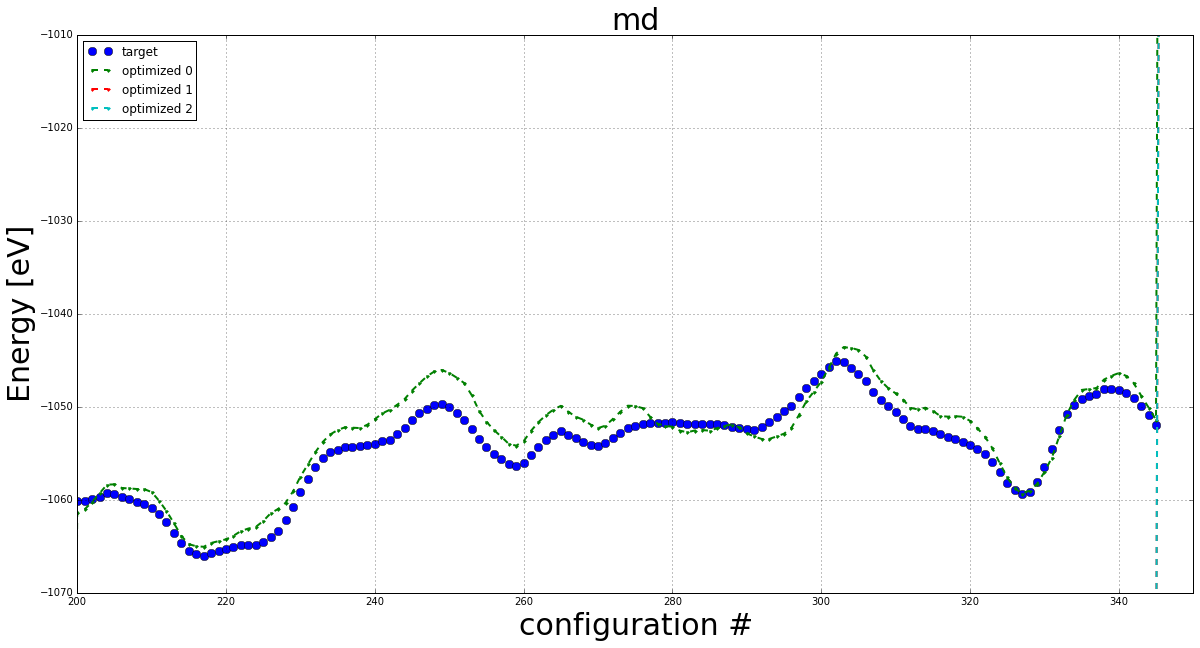

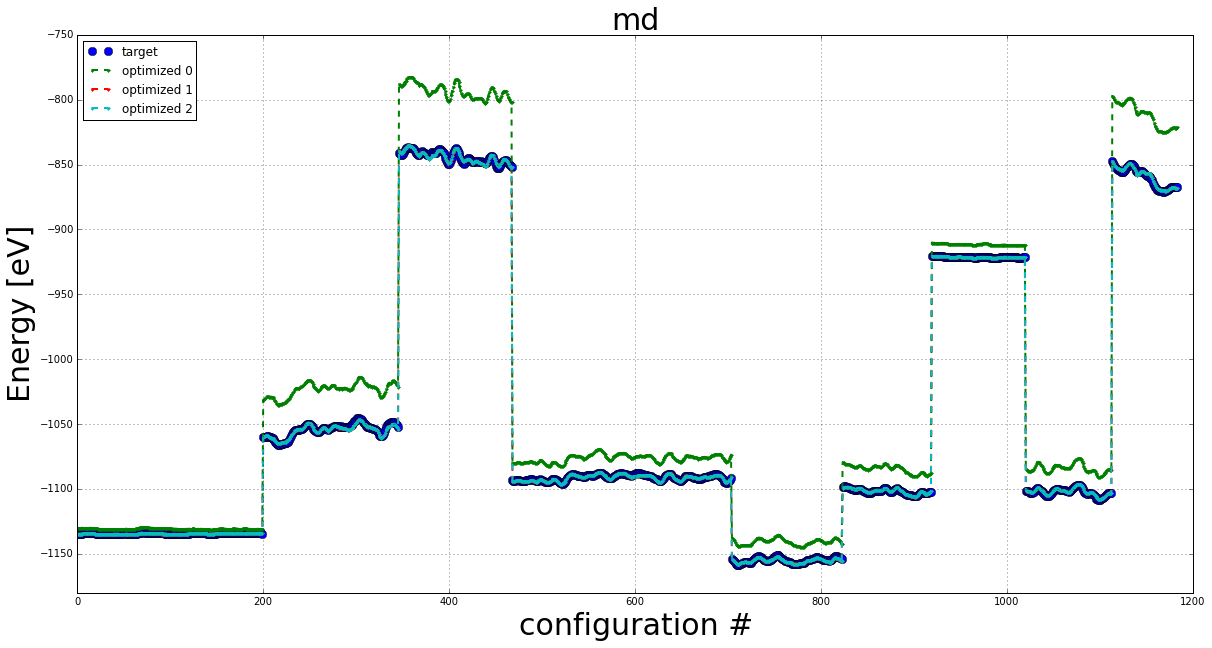

In [502]:
# plot MD trajectories
x_lim = (350,520)
x_lim = (650, 900)
x_lim = (350,450)
#x_lim = (200, 380)
#x_lim = (1120, 1200)
x_lim = (480, 700)
y_lim = (-860,-780)
#y_lim = (-1140,-1090)
y_lim = (-940,-880)
#y_lim = (-880, -820)
y_lim = (-925,-910)
#y_lim = (-1075, -1035)
y_lim = (-1140,-1130)
y_lim = (-1100, -1080)

plot_udif(targets, stats, 'md', optimal_params, x_lim=x_lim, y_lim=y_lim, shift=0)
plot_udif(targets, stats, 'md', optimal_params, x_lim=x_lim, y_lim=y_lim, shift=-15)


x_lim = (930, 1020)
y_lim = (-923, -920)


plot_udif(targets, stats, 'md', optimal_params, x_lim=x_lim, y_lim=y_lim, shift=0)
plot_udif(targets, stats, 'md', optimal_params, x_lim=x_lim, y_lim=y_lim, shift=-10)



x_lim = (0,200)
y_lim = (-1140,-1130)

plot_udif(targets, stats, 'md', optimal_params, x_lim=x_lim, y_lim=y_lim, shift=0)

x_lim = (200,350)
y_lim = (-1070, -1010)
plot_udif(targets, stats, 'md', optimal_params[:], x_lim=x_lim, y_lim=y_lim, shift=0)

x_lim = (200,350)
y_lim = (-1070, -1010)
plot_udif(targets, stats, 'md', optimal_params[:], x_lim=x_lim, y_lim=y_lim, shift=-30)


x_lim = (0, 1200)
y_lim = (-1180, -750)
plot_udif(targets, stats, 'md', optimal_params[:], x_lim=x_lim, y_lim=y_lim, shift=0)

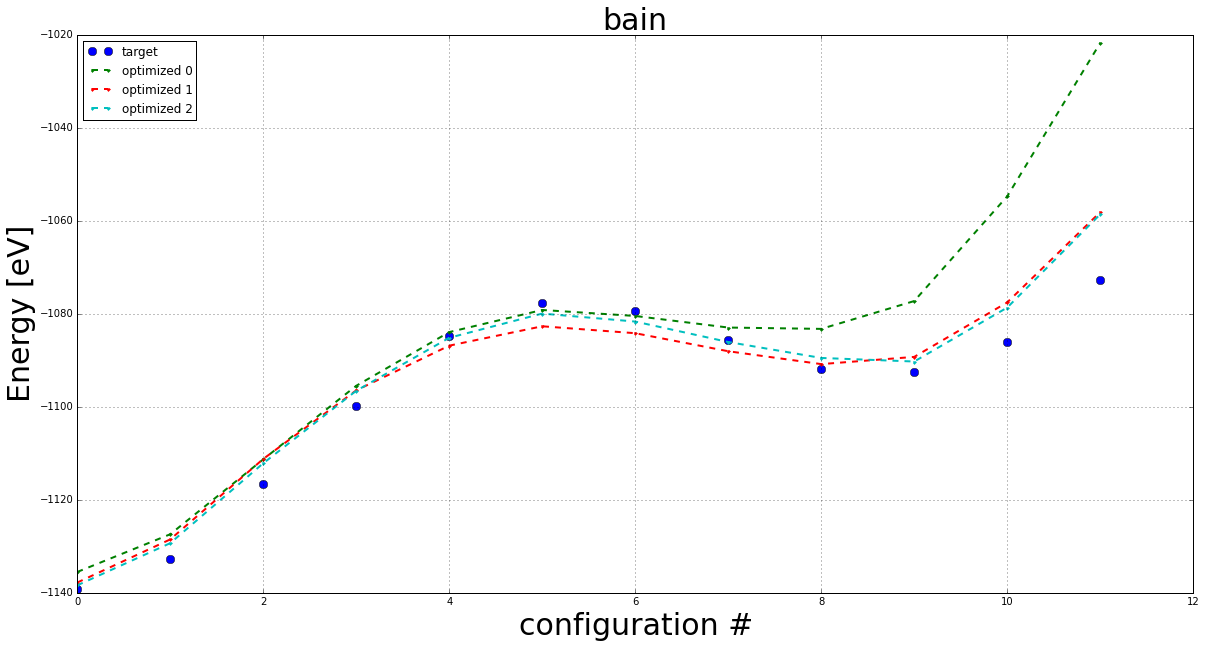

In [503]:
# plot MD trajectories
x_lim = (380,420)
y_lim = (-900,-780)
plot_udif(targets, stats, 'bain', optimal_params, shift=0)#, x_lim=x_lim, y_lim=y_lim)

In [504]:
optimal_params

[(0.0, array([ -5.94645400e+00,  -4.94770000e-02,   0.00000000e+00,
           0.00000000e+00,   9.60851701e+01,  -1.84410924e+02,
           9.35784080e+01,   0.00000000e+00,  -7.98358265e+00,
           7.47034093e+00,  -1.52756044e+00,   1.25205933e+00,
           1.63082162e+00,  -1.41854775e+00,  -8.19936046e-01,
           1.98013514e+00,  -6.96430180e-01,   3.04546910e-02,
          -1.63131143e+00,   1.38409896e+00,   0.00000000e+00,
          -4.20429108e+00,   0.00000000e+00,   0.00000000e+00,
           5.18217702e-01,   5.62720800e-02,   0.00000000e+00,
           3.44164179e-02])),
 (9.82359859228679e-07,
  array([ -3.34519702e+00,   7.66822271e-04,  -4.03553412e+02,
           1.55282185e+01,   2.90516401e+01,  -6.23087513e+01,
           8.48184009e+01,   0.00000000e+00,  -3.48806112e+01,
           9.13550274e+00,   5.96096071e+00,   2.54062374e+00,
           2.39873080e-01,  -7.19239652e-01,  -1.04267291e+00,
           2.29366373e+00,  -7.05206149e-01,  -2.72279799e-

In [506]:
# select which parameters will be used for force field file
n_params = [2, 18, 8, 0]
optimal_list = []
for par in optimal_params:
    optimal_list.append(to_param_dict(par[1], n_params))

In [507]:
optimal_list

[{'params': {'edens': array([ 0.        , -4.20429108,  0.        ,  0.        ,  0.5182177 ,
           0.05627208,  0.        ,  0.03441642]),
   'embed': array([-5.946454, -0.049477]),
   'lrcorr': array([], dtype=float64),
   'pair': array([  0.00000000e+00,   0.00000000e+00,   9.60851701e+01,
           -1.84410924e+02,   9.35784080e+01,   0.00000000e+00,
           -7.98358265e+00,   7.47034093e+00,  -1.52756044e+00,
            1.25205933e+00,   1.63082162e+00,  -1.41854775e+00,
           -8.19936046e-01,   1.98013514e+00,  -6.96430180e-01,
            3.04546910e-02,  -1.63131143e+00,   1.38409896e+00])}},
 {'params': {'edens': array([ -2.01431222e+02,   3.24297105e+01,   3.81664135e+01,
           -2.18948938e+01,   1.02484895e+01,   2.20300623e-01,
            1.13874983e-01,   0.00000000e+00]),
   'embed': array([ -3.34519702e+00,   7.66822271e-04]),
   'lrcorr': array([], dtype=float64),
   'pair': array([ -4.03553412e+02,   1.55282185e+01,   2.90516401e+01,
           -6.

In [508]:
# Total pair potential
pos = targets['relax']['xyz'][0]
bx = targets['relax']['box'][0]
rr, rx = pair_dist_cutoff(pos, bx, 5.5)

In [509]:
# embedding function
F = lambda d, a: a[0]*d**0.5 + a[1]*d**2

V = lambda r, aa, cc: sum([a*(rc - r)**3 for a, rc in zip(aa, cc) if r < rc])

# Cohesive potential (cubic splines - same form as V)
phi = lambda r, aa, cc: sum([a*(rc - r)**3 for a, rc in zip(aa, cc) if r < rc and r > 0.01])

rho = lambda r, aa, kk: sum([a*(rk - r)**3 for a, rk in zip(aa, kk) if r < rk and r > 0.01])

In [510]:
def eos_ene(ff_id):
    
    # spline knots
    V_x_r = stats['hyperparams']['pair']
    rho_x_r = stats['hyperparams']['edens']

    # parameters
    pair_y = optimal_list[ff_id]['params']['pair']
    many_y = optimal_list[ff_id]['params']['embed']
    rho_x_a = optimal_list[ff_id]['params']['edens']

    ene = []
    for a in np.linspace(0.5, 2.0, 101):
        z = a*rr
        u_pair = 0.5*np.sum([V(x, pair_y, V_x_r) for x in z.flatten() if x > 0.1])

        u_many = 0.0
        for i in range(z.shape[0]):
            d = np.sum([phi(x, rho_x_a, rho_x_r) for x in z[i] if x > 0.1])
            u_many += F(d, many_y)

        ene.append([a, u_pair, u_many, u_pair+u_many])

    return np.array(ene)

In [513]:
#ene_mar = eos_ene(0)
#ene_my = eos_ene(1)
ene_mye = eos_ene(2)

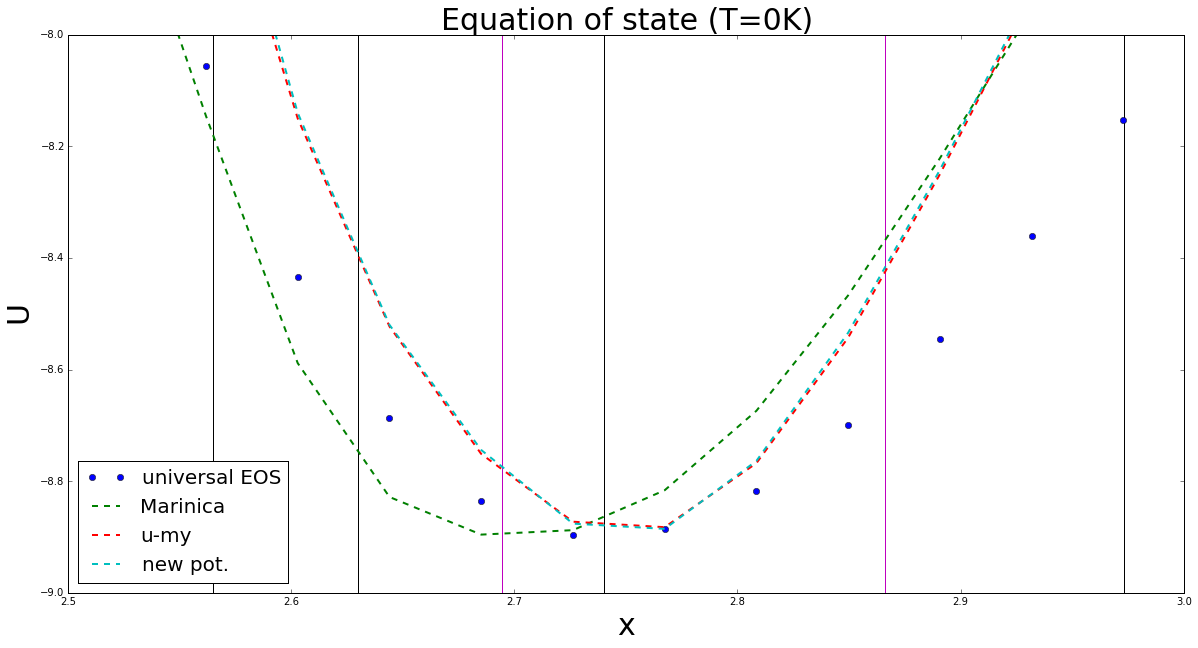

In [518]:
plt.figure(figsize=(20,10))

plt.title('Equation of state (T=0K)', fontsize=30)

plt.plot(ene_my[:,0]*2.74, [universal_eos(x, 'W') for x in ene_my[:,0]], 'bo', label='universal EOS')
plt.plot(ene_mar[:,0]*2.74, ene_mar[:,3]/128,'--', lw=2, label='Marinica', color='g')
plt.plot(ene_my[:,0]*2.74, ene_my[:,3]/128, '--', lw=2, label='u-my', color='r')
plt.plot(ene_mye[:,0]*2.74, ene_mye[:,3]/128 ,'--', lw=2, label='new pot.', color='c')
plt.scatter(stats['hyperparams']['pair'], np.zeros(len(stats['hyperparams']['pair'])))
plt.vlines(stats['hyperparams']['pair']+[2.22], -10, 0)
plt.vlines(stats['hyperparams']['edens'], -10, 0, colors='m')

#plt.vlines(np.linspace(2.25, 5.5, 14), -10, 0, colors='r')
#plt.vlines([2.26, 2.5 , 2.66, 2.74, 2.86, 3.06, 3.30, 3.62 , 3.9, 4.22, 4.54, 4.86, 5.18, 5.5], -10, 0, colors='g')

plt.hlines(0.0,0.5,6.0,lw=1)
plt.legend(loc='best', fontsize=20)
plt.xlim(2.0, 5.82)
plt.xlim(2.5, 3.)
plt.ylim(-10,0.4)
plt.ylim(-9.,-8.)

plt.xlabel('x', fontsize=30)
plt.ylabel(r'U', fontsize=30)
plt.savefig(os.path.join(reports, 'universal_eos'+'.png'))

In [469]:
[(key, targets[key]['weight']) for key in targets]

[('bcc_npt_langevin_3700K', 1.0),
 ('md', 1.0),
 ('vac_npt_langevin_2000K', 1.0),
 ('relax', 1.0),
 ('screw_111_npt_langevin_2000K', 1.0),
 ('bcc_npt_langevin_300K', 1.0),
 ('i111_npt_langevin_2000K', 1.0),
 ('eos', 1.0),
 ('fcc_npt_langevin_300K', 1.0),
 ('eos_fcc', 1.0),
 ('i110_npt_langevin_2000K', 1.0),
 ('liq_3700K', 1.0),
 ('liq_5000K', 1.0),
 ('eos_bcc', 1.0),
 ('bain', 1.0)]

In [471]:
# select which parameters will be used for force field file
n_params = [2, 17, 8, 0]
optimal_list = []
for par in optimal_params:
    optimal_list.append(to_param_dict(par[1], n_params))

In [472]:
# convert lists of optimal parameters to dictionaries
params_dicts = []
for params in optimal_params:
    params_dicts.append(to_param_dict(params[1], stats['hyperparams']))

In [473]:
# #%%writefile -a ../../statmechlib/statmechlib/read_write/write_params_pickle.py

# def params_to_pickle(params_dict, params_pickle, option='r+b', protocol=2):
#     """
#     Store hyperparameters and output parameters in a pickle.
#     By default, append new parameters to an existing file and create a new one if it does not exist
#     """
    
#     if not isinstance(params_dict, dict):
#         raise ValueError('Parameters not in dict form.')

#     params_store = []

#     if option == 'r+b':
#         try:
#             with open(params_pickle, 'rb') as fi:
#                 params_store.extend(pickle.load(fi))
#         except IOError:
#             print('No existing params file, creating a new one.')
    
#     params_store.append(params_dict)

#     with open(params_pickle, 'wb') as fo:
#         pickle.dump(params_store, fo, protocol=protocol)

In [474]:
file_name = os.path.join(working, "params_optimal.pickle")

for params in params_dicts:
    params_to_pickle(params, file_name)

In [475]:
with open(file_name, 'rb') as fi:
    params_store = pickle.load(fi)

In [476]:
ff_id = -1

# spline knots
pair_r = stats['hyperparams']['pair']
rho_r = stats['hyperparams']['edens']

# parameters
pair_a = optimal_list[ff_id]['params']['pair']
rho_a = optimal_list[ff_id]['params']['edens']
many_a = optimal_list[ff_id]['params']['embed']

In [477]:
print(many_a)

[ -3.36853915e+00   8.06754487e-04]


In [1393]:
# find electronic density maximum
rmax = max([(phi(r, rho_a, rho_r), r) for r in np.linspace(2.0, 4.9, 10000)])
rho_max, r_max = rmax
rho_max, r_max
rhomax = 12.0*phi(r_max, rho_a, rho_r)
rmax, rhomax

((22.085469153498732, 2.0), 265.02562984198477)

In [1394]:
# Ranges of densities and separations

nr = 5000
rcut = pair_r[-1]#stats_opt['hyperparams'][-1]
dr = rcut/nr

rhomax = 12.0*phi(r_max, rho_a, rho_r)
print('rhomax:', rhomax)
#rhomax = 10.0
nrho = 5000
drho = rhomax/nrho

ri = 1.0
ro = 2.0

# W properties
na = 74
ma = 183.84
lc = 3.1653
alat = 'bcc'

# System composition
n_el = 1
el_name = ['W']

('rhomax:', 265.02562984198477)


In [1395]:
def u_trans(r, unucl, ueq, ri=1.0, ro=2.0):
    """Transition between the core and equillibrium potentials"""
    if r < ri:
        return unucl
    elif r < ro:
        x = (ro + ri - 2*r)/(ro - ri)
        eta = 3/16*x**5 - 5/8*x**3 + 15/16*x + 1/2
        return ueq + eta*(unucl - ueq)
    else:
        return ueq

In [1396]:
# prepare lists of values
dens = np.linspace(0., rhomax-drho, nrho, endpoint=True)
r = np.linspace(0., rcut-dr, nr, endpoint=True)
r2 = np.linspace(0., rcut, 201)

fembd = [F(d, many_a) for d in dens] # W
edens = np.array([phi(x, rho_a, rho_r) if x > r_max else rho_max for x in r])

# 1. Cubic spline for r > r_o
f_outer = [V(x, pair_a, pair_r) for i, x in enumerate(r)]
# 2. Repulsive core for r < r_i (precalculate up to r_o)
f_inner = [0.0] + [u_core(x) for x in r[1:]]
# 3. Transition region for r_i < r < r_o
fpair = [x*u_trans(x, f_inner[i], f_outer[i]) for i, x in enumerate(r)]
#fpair = f_outer

In [1397]:
# LAMMPS format

with open(os.path.join(pot_path, 'W_zeroenx.eam.fs'), 'w') as fo:
    
    # Comment section
    fo.write('Comment 1\n')
    fo.write('Comment 2\n')
    fo.write('Comment 3\n')
    
    # Number of elements
    #fo.write(f"{n_el:5d} ")
    fo.write("{0:5d} ".format(n_el))

    for i in range(n_el):
        #fo.write(f"{el_name[i]:2}")
        fo.write("{0:2}".format(el_name[i]))
    fo.write("\n")
    
    # number of grid points, step size, and cutoff
    #fo.write(f"{nrho:5d}{drho:24.16e}{nr:5d}{dr:24.16e}{rcut:24.16e}\n")
    fo.write("{0:5d}{1:24.16e}{2:5d}{3:24.16e}{4:24.16e}\n".format(nrho, drho, nr, dr, rcut))

    # atomic number, mass, lattice size, lattice type
    #fo.write(f"{na:5d} {ma:14.4f} {lc:14.4f} {alat:10}\n")
    fo.write("{0:5d} {1:14.4f} {2:14.4f} {3:10}\n".format(na, ma, lc, alat))

    
    # Embeding function
    for i in range(nrho//4):
        fo.write("{0:20.12e}{1:20.12e}{2:20.12e}{3:20.12e}\n".format(*fembd[i*4:i*4+4]))
    
    # Electronic density
    for i in range(nr//4):
        fo.write("{0:20.12e}{1:20.12e}{2:20.12e}{3:20.12e}\n".format(*edens[i*4:i*4+4]))
        
    # Pair potential
    for i in range(nr//4):
        fo.write("{0:20.12e}{1:20.12e}{2:20.12e}{3:20.12e}\n".format(*fpair[i*4:i*4+4]))

In [ ]:
# Yuri's format

with open(os.path.join(pot_path, 'W_pair.yuri'), 'w') as fo:
    
    # Comment section
    fo.write('Comment 1\n')
    fo.write('Comment 2\n')
    fo.write('Comment 3\n')
    
    # Number of elements
    #fo.write(f"{n_el:5d} ")
    fo.write("{0:5d} ".format(n_el))

    for i in range(n_el):
        #fo.write(f"{el_name[i]:2}")
        fo.write("{0:2}".format(el_name[i]))
    fo.write("\n")
    
    # number of grid points, step size, and cutoff
    #fo.write(f"{nrho:5d}{drho:24.16e}{nr:5d}{dr:24.16e}{rcut:24.16e}\n")
    fo.write("{0:5d}{1:24.16e}{2:5d}{3:24.16e}{4:24.16e}\n".format(nrho, drho, nr, dr, rcut))

    # atomic number, mass, lattice size, lattice type
    #fo.write(f"{na:5d} {ma:14.4f} {lc:14.4f} {alat:10}\n")
    fo.write("{0:5d} {1:14.4f} {2:14.4f} {3:10}\n".format(na, ma, lc, alat))

    
    # Embeding function
    for i in range(nrho//4):
        fo.write("{0:20.12e}{1:20.12e}{2:20.12e}{3:20.12e}\n".format(*fembd[i*4:i*4+4]))
    
    # Electronic density
    for i in range(nr//4):
        fo.write("{0:20.12e}{1:20.12e}{2:20.12e}{3:20.12e}\n".format(*edens[i*4:i*4+4]))
        
    # Pair potential
    for i in range(nr//4):
        fo.write("{0:20.12e}{1:20.12e}{2:20.12e}{3:20.12e}\n".format(*fpair[i*4:i*4+4]))